<a href="https://colab.research.google.com/github/Magferat/p2_models/blob/main/dan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall -y torch torchvision torchaudio
!pip cache purge


Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Files removed: 0


In [2]:
pip install torch  torchaudio matplotlib scikit-learn tqdm ipywidgets notebook soundfile audioread librosa seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.1/888.1 MB 867.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.2/287.2 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3

In [3]:
import torch
print(torch.__version__)
print(torch.version.cuda)


2.8.0+cu128
12.8


In [4]:
# Standard libraries
import os
import random
import math
import pickle

# Numerical and data handling
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from torch.utils import data
from torch.nn.parameter import Parameter
from torch.autograd import Variable
from collections import OrderedDict

# Torchaudio
import torchaudio
import torchaudio.transforms as T

# Display
import IPython.display as ipd

# Sklearn metrics and tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    precision_recall_curve, average_precision_score,
    roc_curve, confusion_matrix
)

# SciPy for EER calculation
from scipy.optimize import brentq
from scipy.interpolate import interp1d

# Progress bar
from tqdm import tqdm


import librosa


In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
dataset_path = '/content/drive/MyDrive/Dataset'
# dataset_path = r"C:\Users\T2420353\detect_dp_fk_24\Dataset"

train_path = os.path.join(dataset_path, 'Train')
test_path = os.path.join(dataset_path, 'Test')


In [7]:
import os
print(os.listdir(train_path)[:10])
print(os.listdir(test_path)[:10])


['Fake_vc_C51_B_018.wav', 'Fake_vc_C51_B_007.wav', 'Fake_vc_C51_B_005.wav', 'Fake_vc_C51_B_006.wav', 'Fake_vc_C51_B_002.wav', 'Fake_vc_C51_B_003.wav', 'Fake_vc_C51_B_004.wav', 'Fake_vc_C51_B_014.wav', 'Fake_vc_C51_B_020.wav', 'Fake_vc_C51_B_009.wav']
['Real_M_P29_E_018.wav', 'Real_M_P29_E_017.wav', 'Real_M_P29_E_010.wav', 'Real_M_P29_E_012.wav', 'Real_M_P29_E_001.wav', 'Real_M_P29_E_009.wav', 'Real_M_P29_E_011.wav', 'Real_M_P29_E_013.wav', 'Real_M_P29_E_007.wav', 'Real_M_P29_E_002.wav']


In [8]:
def parse_filename(name):
    name = name.strip()
    if name.startswith('Real'):
        parts = name.replace('.wav', '').split('_')
        return {
            'path': name,
            'label': 0,
            'fake_type': 'Real',
            'gender': 'Female' if parts[1] == 'F' else 'Male',
            'id': parts[2].strip(),
            'set': parts[3].strip(),
            'sentence': int(parts[4])
        }

    elif name.startswith('Fake_tts'):
        parts = name.replace('.wav', '').split('_')
        return {
            'path': name,
            'label': 1,
            'fake_type': 'TTS',
            'gender': 'Female' if parts[2] == 'F' else 'Male',
            'id': parts[3].strip(),
            'set': parts[4].strip(),
            'sentence': int(parts[5])
        }

    elif name.startswith('Fake_vc'):
        parts = name.replace('.wav', '').split('_')
        return {
            'path': name,
            'label': 1,
            'fake_type': 'VC',
            'gender': None,
            'id': parts[2].strip(),
            'set': parts[3].strip(),
            'sentence': int(parts[4])
        }

    else:
        return None


In [9]:


def get_file_df(folder):
    rows = []
    for name in os.listdir(folder):
        if name.endswith('.wav'):
            data = parse_filename(name)
            if data:
                full_path = os.path.join(folder, data['path'])
                try:
                    # wav, sr = librosa.load(full_path, sr=None)
                    wav, sr = librosa.load(full_path, sr=None, res_type='kaiser_fast')
                    duration_sec = len(wav) / sr
                    data['duration'] = duration_sec
                    data['samples'] = len(wav)
                    data['sr'] = sr
                except Exception as e:
                    print(f"Error loading {full_path}: {e}")
                    continue
                data['path'] = full_path  # Use full path now
                rows.append(data)
    return pd.DataFrame(rows)


In [10]:



def pad(x, max_len=64000):
    x_len = x.shape[0]
    if x_len >= max_len:
        return x[:max_len]
    num_repeats = int(max_len / x_len) + 1
    padded_x = np.tile(x.numpy(), num_repeats)[:max_len]
    return torch.tensor(padded_x, dtype=torch.float32)

def init_weights(m):
    if isinstance(m, nn.Linear):
        # torch.nn.init.xavier_uniform(m.weight)
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.0001)
    elif isinstance(m, nn.BatchNorm1d):
        pass
    else:
        if hasattr(m, 'weight'):
            nn.init.kaiming_normal_(m.weight, a=0.01)

class AudioDataset(Dataset):
    def __init__(self, dataframe, transform=None, target_sr=16000):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform
        self.target_sr = target_sr

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row['path']

        # # torchaudio load
        try:
            wav, sr = torchaudio.load(path)
            wav = wav[0]
        except:
          # wav_np, sr = librosa.load(path, sr=None)
          wav_np, sr = librosa.load(path, sr=None, res_type='kaiser_fast')
          wav = torch.tensor(wav_np, dtype=torch.float32)

        # Resample if needed
        if sr != self.target_sr:
            resampler = T.Resample(orig_freq=sr, new_freq=self.target_sr)
            wav = resampler(wav)

        # Silence trim using librosa
        wav_np = wav.numpy()
        wav_trimmed, _ = librosa.effects.trim(wav_np, top_db=20)
        wav = torch.tensor(wav_trimmed, dtype=torch.float32)

        if self.transform:
            wav = self.transform(wav)

        return wav, row['label']


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import numpy as np
import math
from torch.utils import data
from collections import OrderedDict
from torch.nn.parameter import Parameter
from torch.autograd import Variable
import pickle
import random

class SincConv(nn.Module):
    @staticmethod
    def to_mel(hz):
        return 2595 * np.log10(1 + hz / 700)

    @staticmethod
    def to_hz(mel):
        return 700 * (10 ** (mel / 2595) - 1)


    def __init__(self, device,out_channels, kernel_size,in_channels=1,sample_rate=16000,
                 stride=1, padding=0, dilation=1, bias=False, groups=1,freq_scale='Mel'):

        super(SincConv,self).__init__()


        if in_channels != 1:

            msg = "SincConv only support one input channel (here, in_channels = {%i})" % (in_channels)
            raise ValueError(msg)

        self.out_channels = out_channels+1
        self.kernel_size = kernel_size
        self.sample_rate=sample_rate

        # Forcing the filters to be odd (i.e, perfectly symmetrics)
        if kernel_size%2==0:
            self.kernel_size=self.kernel_size+1

        self.device=device
        self.stride = stride
        self.padding = padding
        self.dilation = dilation

        if bias:
            raise ValueError('SincConv does not support bias.')
        if groups > 1:
            raise ValueError('SincConv does not support groups.')


        # initialize filterbanks using Mel scale
        NFFT = 512
        f=int(self.sample_rate/2)*np.linspace(0,1,int(NFFT/2)+1)


        if freq_scale == 'Mel':
            fmel=self.to_mel(f) # Hz to mel conversion
            fmelmax=np.max(fmel)
            fmelmin=np.min(fmel)
            filbandwidthsmel=np.linspace(fmelmin,fmelmax,self.out_channels+2)
            filbandwidthsf=self.to_hz(filbandwidthsmel) # Mel to Hz conversion
            self.freq=filbandwidthsf[:self.out_channels]

        elif freq_scale == 'Inverse-mel':
            fmel=self.to_mel(f) # Hz to mel conversion
            fmelmax=np.max(fmel)
            fmelmin=np.min(fmel)
            filbandwidthsmel=np.linspace(fmelmin,fmelmax,self.out_channels+2)
            filbandwidthsf=self.to_hz(filbandwidthsmel) # Mel to Hz conversion
            self.mel=filbandwidthsf[:self.out_channels]
            self.freq=np.abs(np.flip(self.mel)-1) ## invert mel scale


        else:
            fmelmax=np.max(f)
            fmelmin=np.min(f)
            filbandwidthsmel=np.linspace(fmelmin,fmelmax,self.out_channels+2)
            self.freq=filbandwidthsmel[:self.out_channels]

        self.hsupp=torch.arange(-(self.kernel_size-1)/2, (self.kernel_size-1)/2+1)
        self.band_pass=torch.zeros(self.out_channels-1,self.kernel_size)



    def forward(self,x):
        for i in range(len(self.freq)-1):
            fmin=self.freq[i]
            fmax=self.freq[i+1]
            hHigh=(2*fmax/self.sample_rate)*np.sinc(2*fmax*self.hsupp/self.sample_rate)
            hLow=(2*fmin/self.sample_rate)*np.sinc(2*fmin*self.hsupp/self.sample_rate)
            hideal=hHigh-hLow

            self.band_pass[i,:]=Tensor(np.hamming(self.kernel_size))*Tensor(hideal)

        band_pass_filter=self.band_pass.to(self.device)

        self.filters = (band_pass_filter).view(self.out_channels-1, 1, self.kernel_size)

        return F.conv1d(x, self.filters, stride=self.stride,
                        padding=self.padding, dilation=self.dilation,
                         bias=None, groups=1)



class Residual_block(nn.Module):
    def __init__(self, nb_filts, first = False):
        super(Residual_block, self).__init__()
        self.first = first

        if not self.first:
            self.bn1 = nn.BatchNorm1d(num_features = nb_filts[0])

        self.lrelu = nn.LeakyReLU(negative_slope=0.3)

        self.conv1 = nn.Conv1d(in_channels = nb_filts[0], out_channels = nb_filts[1], kernel_size = 3, padding = 1, stride = 1)

        self.bn2 = nn.BatchNorm1d(num_features = nb_filts[1])
        self.conv2 = nn.Conv1d(in_channels = nb_filts[1], out_channels = nb_filts[1], padding = 1, kernel_size = 3, stride = 1)

        if nb_filts[0] != nb_filts[1]:
            self.downsample = True
            self.conv_downsample = nn.Conv1d(in_channels = nb_filts[0], out_channels = nb_filts[1], padding = 0, kernel_size = 1, stride = 1)

        else:
            self.downsample = False
        self.mp = nn.MaxPool1d(3)

    def forward(self, x):
        identity = x
        if not self.first:
            out = self.bn1(x)
            out = self.lrelu(out)
        else:
            out = x

        out = self.conv1(out)
        out = self.bn2(out)
        out = self.lrelu(out)
        out = self.conv2(out)

        if self.downsample:
            identity = self.conv_downsample(identity)

        out += identity
        out = self.mp(out)
        return out





class RawNet(nn.Module):
    def __init__(self, d_args, device):
        super(RawNet, self).__init__()


        self.device=device

        self.Sinc_conv=SincConv(device=self.device, out_channels = d_args['filts'][0], kernel_size = d_args['first_conv'], in_channels = d_args['in_channels'],freq_scale='Mel'
                                    )

        self.first_bn = nn.BatchNorm1d(num_features = d_args['filts'][0])
        self.selu = nn.SELU(inplace=True)
        self.block0 = nn.Sequential(Residual_block(nb_filts = d_args['filts'][1], first = True))
        self.block1 = nn.Sequential(Residual_block(nb_filts = d_args['filts'][1]))
        self.block2 = nn.Sequential(Residual_block(nb_filts = d_args['filts'][2]))
        d_args['filts'][2][0] = d_args['filts'][2][1]
        self.block3 = nn.Sequential(Residual_block(nb_filts = d_args['filts'][2]))
        self.block4 = nn.Sequential(Residual_block(nb_filts = d_args['filts'][2]))
        self.block5 = nn.Sequential(Residual_block(nb_filts = d_args['filts'][2]))
        self.avgpool = nn.AdaptiveAvgPool1d(1)

        self.fc_attention0 = self._make_attention_fc(in_features = d_args['filts'][1][-1], l_out_features = d_args['filts'][1][-1])
        self.fc_attention1 = self._make_attention_fc(in_features = d_args['filts'][1][-1], l_out_features = d_args['filts'][1][-1])
        self.fc_attention2 = self._make_attention_fc(in_features = d_args['filts'][2][-1], l_out_features = d_args['filts'][2][-1])
        self.fc_attention3 = self._make_attention_fc(in_features = d_args['filts'][2][-1], l_out_features = d_args['filts'][2][-1])
        self.fc_attention4 = self._make_attention_fc(in_features = d_args['filts'][2][-1], l_out_features = d_args['filts'][2][-1])
        self.fc_attention5 = self._make_attention_fc(in_features = d_args['filts'][2][-1], l_out_features = d_args['filts'][2][-1])

        self.bn_before_gru = nn.BatchNorm1d(num_features = d_args['filts'][2][-1])
        self.gru = nn.GRU(input_size = d_args['filts'][2][-1], hidden_size = d_args['gru_node'], num_layers = d_args['nb_gru_layer'], batch_first = True)

        self.fc1_gru = nn.Linear(in_features = d_args['gru_node'], out_features = d_args['nb_fc_node'])

        self.fc2_gru = nn.Linear(in_features = d_args['nb_fc_node'], out_features = d_args['nb_classes'],bias=True)

        self.sig = nn.Sigmoid()


    def forward(self, x, y = None,is_test=False):


        nb_samp = x.shape[0]
        len_seq = x.shape[1]
        x=x.view(nb_samp,1,len_seq)

        x = self.Sinc_conv(x)    # Fixed sinc filters convolution
        x = F.max_pool1d(torch.abs(x), 3)
        x = self.first_bn(x)
        x = self.selu(x)

        x0 = self.block0(x)
        y0 = self.avgpool(x0).view(x0.size(0), -1) # torch.Size([batch, filter])
        y0 = self.fc_attention0(y0)
        y0 = self.sig(y0).view(y0.size(0), y0.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x0 * y0 + y0  # (batch, filter, time) x (batch, filter, 1)


        x1 = self.block1(x)
        y1 = self.avgpool(x1).view(x1.size(0), -1) # torch.Size([batch, filter])
        y1 = self.fc_attention1(y1)
        y1 = self.sig(y1).view(y1.size(0), y1.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x1 * y1 + y1 # (batch, filter, time) x (batch, filter, 1)

        x2 = self.block2(x)
        y2 = self.avgpool(x2).view(x2.size(0), -1) # torch.Size([batch, filter])
        y2 = self.fc_attention2(y2)
        y2 = self.sig(y2).view(y2.size(0), y2.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x2 * y2 + y2 # (batch, filter, time) x (batch, filter, 1)

        x3 = self.block3(x)
        y3 = self.avgpool(x3).view(x3.size(0), -1) # torch.Size([batch, filter])
        y3 = self.fc_attention3(y3)
        y3 = self.sig(y3).view(y3.size(0), y3.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x3 * y3 + y3 # (batch, filter, time) x (batch, filter, 1)

        x4 = self.block4(x)
        y4 = self.avgpool(x4).view(x4.size(0), -1) # torch.Size([batch, filter])
        y4 = self.fc_attention4(y4)
        y4 = self.sig(y4).view(y4.size(0), y4.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x4 * y4 + y4 # (batch, filter, time) x (batch, filter, 1)

        x5 = self.block5(x)
        y5 = self.avgpool(x5).view(x5.size(0), -1) # torch.Size([batch, filter])
        y5 = self.fc_attention5(y5)
        y5 = self.sig(y5).view(y5.size(0), y5.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x5 * y5 + y5 # (batch, filter, time) x (batch, filter, 1)

        x = self.bn_before_gru(x)
        x = self.selu(x)
        x = x.permute(0, 2, 1)     #(batch, filt, time) >> (batch, time, filt)
        self.gru.flatten_parameters()
        x, _ = self.gru(x)
        x = x[:,-1,:]
        x = self.fc1_gru(x)
        x = self.fc2_gru(x)

        if not is_test:
            output = x
            return output

        else:
            output=F.softmax(x,dim=1)
            return output




    def _make_attention_fc(self, in_features, l_out_features):

        l_fc = []

        l_fc.append(nn.Linear(in_features = in_features,
			        out_features = l_out_features))



        return nn.Sequential(*l_fc)


    def _make_layer(self, nb_blocks, nb_filts, first = False):
        layers = []
        #def __init__(self, nb_filts, first = False):
        for i in range(nb_blocks):
            first = first if i == 0 else False
            layers.append(Residual_block(nb_filts = nb_filts,
				first = first))
            if i == 0: nb_filts[0] = nb_filts[1]

        return nn.Sequential(*layers)

In [12]:
# # Setup

df = get_file_df(train_path)
df = df.sample(frac=1).reset_index(drop=True)
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'])


df_tts = train_df[train_df['fake_type'].isin(['Real', 'TTS'])].reset_index(drop=True)
df_vc = train_df[train_df['fake_type'].isin(['Real', 'VC'])].reset_index(drop=True)
df_overall = train_df.copy().reset_index(drop=True)

dataset_variants = {
    "tts": df_tts,
    "vc": df_vc,
    "overall": df_overall
}

transform = lambda x: pad(x, max_len=64000)

val_dataset = AudioDataset(val_df, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

/tmp/ipython-input-1180288354.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  wav, sr = librosa.load(full_path, sr=None, res_type='kaiser_fast')
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-1180288354.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  wav, sr = librosa.load(full_path, sr=None, res_type='kaiser_fast')
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-1180288354.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  wav, sr = librosa.load(full_path, 

In [13]:
def init_history():
    return {
        'accuracy': [],
        'val_accuracy': [],
        'loss': [],
        'val_loss': [],
        'f1_score': [],
        'val_f1_score': [],
        'precision': [],
        'val_precision': [],
        'recall': [],
        'val_recall': [],
        'eer': []
    }

# Store history for each variant
histories = {}


In [14]:




def train_variant(variant_name, variant_df, history):
    print(f"\n=== Training RawNet2-{variant_name.upper()} ===")

    # Create folder to save models if not exists
    os.makedirs("models", exist_ok=True)
    config = {
    'first_conv': 128,
    'in_channels': 1,
    'filts': [128, [128, 128], [128, 512], [512, 512]],  # Match original
    'nb_fc_node': 1024,
    'gru_node': 1024,
    'nb_gru_layer': 3,
    'nb_classes': 2,
    'nb_samp': 64000
     }


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Create datasets and loaders
    train_dataset = AudioDataset(variant_df, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)

    # Initialize model and move to device
    model = RawNet(config, device=device).to(device)
    model.apply(init_weights)  # Your weight init function
    model = model.to(device)

    # Loss and optimizer
    weight = torch.FloatTensor([1.0, 1.0]).to(device)  # example weights, adjust if needed
    criterion = torch.nn.CrossEntropyLoss(weight=weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0001)

    epochs = 25
    best_acc = 0

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        # --- Training ---
        model.train()
        running_loss = 0
        correct = 0
        total = 0
        train_y_true, train_y_score = [], []

        for x, y in tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False):
            x, y = x.to(device), y.to(device)

            outputs = model(x, y)  #
            loss = criterion(outputs, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

            probs = outputs[:, 1].detach()
            train_y_score.extend(probs.cpu().numpy())
            train_y_true.extend(y.cpu().numpy())

        train_loss = running_loss / total
        train_acc = 100 * correct / total
        train_preds = [1 if s > 0.5 else 0 for s in train_y_score]
        train_precision = precision_score(train_y_true, train_preds)
        train_recall = recall_score(train_y_true, train_preds)
        train_f1 = f1_score(train_y_true, train_preds)

        print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%, "
              f"Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}")

        # --- Validation ---
        model.eval()
        val_running_loss = 0
        correct = 0
        total = 0
        y_true, y_score = [], []

        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x, is_test=True)

                val_loss = criterion(outputs, y)
                val_running_loss += val_loss.item() * x.size(0)

                probs = outputs[:, 1]
                y_score.extend(probs.cpu().numpy())
                y_true.extend(y.cpu().numpy())

                preds = torch.argmax(outputs, dim=1)
                correct += (preds == y).sum().item()
                total += y.size(0)

        val_loss = val_running_loss / total
        val_acc = 100 * correct / total

        # Calculate EER
        fpr, tpr, _ = roc_curve(y_true, y_score)
        eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

        val_preds = [1 if s > 0.5 else 0 for s in y_score]
        val_precision = precision_score(y_true, val_preds)
        val_recall = recall_score(y_true, val_preds)
        val_f1 = f1_score(y_true, val_preds)

        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%, EER: {eer:.4f}, "
              f"Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

        # Store metrics
        history['accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['f1_score'].append(train_f1)
        history['val_f1_score'].append(val_f1)
        history['precision'].append(train_precision)
        history['val_precision'].append(val_precision)
        history['recall'].append(train_recall)
        history['val_recall'].append(val_recall)
        history['eer'].append(eer)

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"models/rawnet2_{variant_name}.pth")
            print(f"Saved best model for {variant_name} with accuracy {best_acc:.4f}")

    print(f"\nBest Validation Accuracy for {variant_name}: {best_acc:.4f}")
    return best_acc


histories['tts'] = init_history()
results_tts = train_variant('tts', df_tts, histories['tts'])

histories['vc'] = init_history()
results_vc = train_variant('vc', df_vc, histories['vc'])

# histories['overall'] = init_history()
# results_overall = train_variant('overall', df_overall, histories['overall'])


# results = {}
# results['tts'] = train_variant('tts', df_tts)
# results['vc'] = train_variant('vc', df_vc)
# results['overall'] = train_variant('overall', df_overall)

# print("\n=== Final Summary ===")
# for k, v in results.items():
#     print(f"{k.upper()}: {v:.4f}")



=== Training RawNet2-TTS ===

Epoch 1/25


Training Epoch 1:   0%|          | 0/96 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pyto

Train Loss: 0.1762, Accuracy: 93.20%, Precision: 0.9267, Recall: 0.8411, F1: 0.8818
Validation Loss: 0.8779, Accuracy: 43.20%, EER: 0.4173, Precision: 0.6296, Recall: 0.0243, F1: 0.0468
Saved best model for tts with accuracy 43.1967

Epoch 2/25


Training Epoch 2:   0%|          | 0/96 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pyto

Train Loss: 0.0681, Accuracy: 97.66%, Precision: 0.9732, Recall: 0.9392, F1: 0.9559
Validation Loss: 0.6946, Accuracy: 61.48%, EER: 0.3771, Precision: 0.9752, Recall: 0.3371, F1: 0.5011
Saved best model for tts with accuracy 61.4754

Epoch 3/25


Training Epoch 3:   0%|          | 0/96 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pyto

Train Loss: 0.0546, Accuracy: 98.01%, Precision: 0.9776, Recall: 0.9590, F1: 0.9682
Validation Loss: 0.6095, Accuracy: 69.92%, EER: 0.2058, Precision: 0.9798, Recall: 0.4857, F1: 0.6495
Saved best model for tts with accuracy 69.9180

Epoch 4/25


Training Epoch 4:   0%|          | 0/96 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pyto

Train Loss: 0.0665, Accuracy: 98.01%, Precision: 0.9785, Recall: 0.9502, F1: 0.9641
Validation Loss: 0.6883, Accuracy: 62.46%, EER: 0.3457, Precision: 0.9879, Recall: 0.3500, F1: 0.5169

Epoch 5/25


Training Epoch 5:   0%|          | 0/96 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pyto

Train Loss: 0.0302, Accuracy: 98.89%, Precision: 0.9859, Recall: 0.9781, F1: 0.9820
Validation Loss: 0.6814, Accuracy: 62.79%, EER: 0.3229, Precision: 0.9960, Recall: 0.3529, F1: 0.5211

Epoch 6/25


Training Epoch 6:   0%|          | 0/96 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pyto

Train Loss: 0.0354, Accuracy: 98.83%, Precision: 0.9878, Recall: 0.9721, F1: 0.9799
Validation Loss: 0.6275, Accuracy: 66.89%, EER: 0.2250, Precision: 0.9713, Recall: 0.4357, F1: 0.6016

Epoch 7/25


Training Epoch 7:   0%|          | 0/96 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pyto

Train Loss: 0.0331, Accuracy: 98.86%, Precision: 0.9849, Recall: 0.9761, F1: 0.9805
Validation Loss: 0.6292, Accuracy: 67.87%, EER: 0.2586, Precision: 0.9724, Recall: 0.4529, F1: 0.6179

Epoch 8/25


Training Epoch 8:   0%|          | 0/96 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pyto

Train Loss: 0.0345, Accuracy: 98.80%, Precision: 0.9869, Recall: 0.9790, F1: 0.9830
Validation Loss: 0.6628, Accuracy: 64.34%, EER: 0.2288, Precision: 1.0000, Recall: 0.3786, F1: 0.5492

Epoch 9/25


Training Epoch 9:   0%|          | 0/96 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pyto

Train Loss: 0.0199, Accuracy: 99.41%, Precision: 0.9929, Recall: 0.9791, F1: 0.9860
Validation Loss: 0.6753, Accuracy: 63.11%, EER: 0.2385, Precision: 1.0000, Recall: 0.3571, F1: 0.5263

Epoch 10/25


Training Epoch 10:   0%|          | 0/96 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pyt

Train Loss: 0.0113, Accuracy: 99.54%, Precision: 0.9960, Recall: 0.9900, F1: 0.9930
Validation Loss: 0.6697, Accuracy: 63.93%, EER: 0.2423, Precision: 1.0000, Recall: 0.3714, F1: 0.5417

Epoch 11/25


Training Epoch 11:   0%|          | 0/96 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pyt

Train Loss: 0.0077, Accuracy: 99.77%, Precision: 0.9990, Recall: 0.9940, F1: 0.9965
Validation Loss: 0.6777, Accuracy: 63.36%, EER: 0.2471, Precision: 1.0000, Recall: 0.3614, F1: 0.5310

Epoch 12/25


Training Epoch 12:   0%|          | 0/96 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pyt

Train Loss: 0.0152, Accuracy: 99.41%, Precision: 0.9960, Recall: 0.9870, F1: 0.9915
Validation Loss: 0.6468, Accuracy: 66.23%, EER: 0.2114, Precision: 0.9898, Recall: 0.4157, F1: 0.5855

Epoch 13/25


Training Epoch 13:   0%|          | 0/96 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pyt

Train Loss: 0.0134, Accuracy: 99.58%, Precision: 0.9950, Recall: 0.9891, F1: 0.9921
Validation Loss: 0.6829, Accuracy: 62.87%, EER: 0.2250, Precision: 1.0000, Recall: 0.3529, F1: 0.5216

Epoch 14/25


Training Epoch 14:   0%|          | 0/96 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pyt

Train Loss: 0.0179, Accuracy: 99.48%, Precision: 0.9940, Recall: 0.9860, F1: 0.9900
Validation Loss: 0.6597, Accuracy: 64.10%, EER: 0.2414, Precision: 0.9925, Recall: 0.3771, F1: 0.5466

Epoch 15/25


Training Epoch 15:   0%|          | 0/96 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pyt

Train Loss: 0.0194, Accuracy: 99.41%, Precision: 0.9940, Recall: 0.9881, F1: 0.9910
Validation Loss: 0.6457, Accuracy: 66.15%, EER: 0.2327, Precision: 0.9898, Recall: 0.4143, F1: 0.5841

Epoch 16/25


Training Epoch 16:   0%|          | 0/96 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pyt

Train Loss: 0.0067, Accuracy: 99.90%, Precision: 0.9980, Recall: 0.9960, F1: 0.9970
Validation Loss: 0.6805, Accuracy: 63.11%, EER: 0.3071, Precision: 0.9960, Recall: 0.3586, F1: 0.5273

Epoch 17/25


Training Epoch 17:   0%|          | 0/96 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pyt

Train Loss: 0.0124, Accuracy: 99.61%, Precision: 0.9950, Recall: 0.9940, F1: 0.9945
Validation Loss: 0.6291, Accuracy: 67.95%, EER: 0.2600, Precision: 0.9968, Recall: 0.4429, F1: 0.6133

Epoch 18/25


Training Epoch 18:   0%|          | 0/96 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pyt

Train Loss: 0.0297, Accuracy: 99.19%, Precision: 0.9900, Recall: 0.9821, F1: 0.9860
Validation Loss: 0.6807, Accuracy: 63.03%, EER: 0.3442, Precision: 0.9960, Recall: 0.3571, F1: 0.5258

Epoch 19/25


Training Epoch 19:   0%|          | 0/96 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pyt

Train Loss: 0.0165, Accuracy: 99.38%, Precision: 0.9940, Recall: 0.9880, F1: 0.9910
Validation Loss: 0.6818, Accuracy: 62.87%, EER: 0.3154, Precision: 0.9881, Recall: 0.3571, F1: 0.5247

Epoch 20/25


Training Epoch 20:   0%|          | 0/96 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pyt

Train Loss: 0.0080, Accuracy: 99.67%, Precision: 0.9970, Recall: 0.9910, F1: 0.9940
Validation Loss: 0.6542, Accuracy: 65.08%, EER: 0.2171, Precision: 0.9928, Recall: 0.3943, F1: 0.5644

Epoch 21/25


Training Epoch 21:   0%|          | 0/96 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pyt

Train Loss: 0.0099, Accuracy: 99.77%, Precision: 0.9980, Recall: 0.9950, F1: 0.9965
Validation Loss: 0.6842, Accuracy: 62.54%, EER: 0.2914, Precision: 0.9959, Recall: 0.3486, F1: 0.5164

Epoch 22/25


Training Epoch 22:   0%|          | 0/96 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pyt

Train Loss: 0.0012, Accuracy: 99.97%, Precision: 1.0000, Recall: 0.9980, F1: 0.9990
Validation Loss: 0.6892, Accuracy: 62.38%, EER: 0.3019, Precision: 0.9959, Recall: 0.3457, F1: 0.5133

Epoch 23/25


Training Epoch 23:   0%|          | 0/96 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pyt

Train Loss: 0.0071, Accuracy: 99.74%, Precision: 0.9990, Recall: 0.9930, F1: 0.9960
Validation Loss: 0.6812, Accuracy: 63.03%, EER: 0.3129, Precision: 0.9921, Recall: 0.3586, F1: 0.5268

Epoch 24/25


Training Epoch 24:   0%|          | 0/96 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pyt

Train Loss: 0.0057, Accuracy: 99.80%, Precision: 0.9960, Recall: 0.9960, F1: 0.9960
Validation Loss: 0.6855, Accuracy: 62.54%, EER: 0.2529, Precision: 0.9959, Recall: 0.3486, F1: 0.5164

Epoch 25/25


Training Epoch 25:   0%|          | 0/96 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pyt

Train Loss: 0.0144, Accuracy: 99.58%, Precision: 0.9950, Recall: 0.9871, F1: 0.9910
Validation Loss: 0.6906, Accuracy: 62.21%, EER: 0.2829, Precision: 1.0000, Recall: 0.3414, F1: 0.5091

Best Validation Accuracy for tts: 69.9180

=== Training RawNet2-VC ===

Epoch 1/25


Training Epoch 1:   0%|          | 0/120 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pyt

Train Loss: 0.2958, Accuracy: 87.99%, Precision: 0.9148, Recall: 0.7732, F1: 0.8381
Validation Loss: 0.5629, Accuracy: 74.10%, EER: 0.2514, Precision: 0.9229, Recall: 0.5986, F1: 0.7262
Saved best model for vc with accuracy 74.0984

Epoch 2/25


Training Epoch 2:   0%|          | 0/120 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pyt

Train Loss: 0.1676, Accuracy: 93.59%, Precision: 0.9526, Recall: 0.8859, F1: 0.9181
Validation Loss: 0.5010, Accuracy: 79.92%, EER: 0.1788, Precision: 0.9400, Recall: 0.6943, F1: 0.7987
Saved best model for vc with accuracy 79.9180

Epoch 3/25


Training Epoch 3:   0%|          | 0/120 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pyt

Train Loss: 0.1276, Accuracy: 95.03%, Precision: 0.9703, Recall: 0.9164, F1: 0.9426
Validation Loss: 0.5269, Accuracy: 78.11%, EER: 0.1904, Precision: 0.9597, Recall: 0.6457, F1: 0.7720

Epoch 4/25


Training Epoch 4:   0%|          | 0/120 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pyt

Train Loss: 0.1227, Accuracy: 95.49%, Precision: 0.9722, Recall: 0.9241, F1: 0.9476
Validation Loss: 0.5310, Accuracy: 77.30%, EER: 0.2000, Precision: 0.9608, Recall: 0.6300, F1: 0.7610

Epoch 5/25


Training Epoch 5:   0%|          | 0/120 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pyt

Train Loss: 0.1025, Accuracy: 96.46%, Precision: 0.9749, Recall: 0.9409, F1: 0.9576
Validation Loss: 0.5119, Accuracy: 79.26%, EER: 0.1886, Precision: 0.9705, Recall: 0.6586, F1: 0.7847

Epoch 6/25


Training Epoch 6:   0%|          | 0/120 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pyt

Train Loss: 0.0703, Accuracy: 97.50%, Precision: 0.9838, Recall: 0.9561, F1: 0.9697
Validation Loss: 0.4936, Accuracy: 80.82%, EER: 0.1192, Precision: 0.9895, Recall: 0.6729, F1: 0.8010
Saved best model for vc with accuracy 80.8197

Epoch 7/25


Training Epoch 7:   0%|          | 0/120 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pyt

Train Loss: 0.0824, Accuracy: 97.21%, Precision: 0.9814, Recall: 0.9498, F1: 0.9653
Validation Loss: 0.4907, Accuracy: 81.31%, EER: 0.1700, Precision: 0.9758, Recall: 0.6914, F1: 0.8094
Saved best model for vc with accuracy 81.3115

Epoch 8/25


Training Epoch 8:   0%|          | 0/120 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pyt

Train Loss: 0.0662, Accuracy: 97.60%, Precision: 0.9839, Recall: 0.9628, F1: 0.9732
Validation Loss: 0.4999, Accuracy: 79.92%, EER: 0.1269, Precision: 0.9892, Recall: 0.6571, F1: 0.7897

Epoch 9/25


Training Epoch 9:   0%|          | 0/120 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pyt

Train Loss: 0.0639, Accuracy: 97.84%, Precision: 0.9856, Recall: 0.9611, F1: 0.9732
Validation Loss: 0.4706, Accuracy: 82.95%, EER: 0.1077, Precision: 0.9824, Recall: 0.7157, F1: 0.8281
Saved best model for vc with accuracy 82.9508

Epoch 10/25


Training Epoch 10:   0%|          | 0/120 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/py

Train Loss: 0.0587, Accuracy: 97.89%, Precision: 0.9862, Recall: 0.9640, F1: 0.9749
Validation Loss: 0.4830, Accuracy: 81.39%, EER: 0.1173, Precision: 0.9876, Recall: 0.6843, F1: 0.8084

Epoch 11/25


Training Epoch 11:   0%|          | 0/120 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/py

Train Loss: 0.0566, Accuracy: 98.12%, Precision: 0.9834, Recall: 0.9679, F1: 0.9756
Validation Loss: 0.5004, Accuracy: 80.33%, EER: 0.1000, Precision: 0.9936, Recall: 0.6614, F1: 0.7942

Epoch 12/25


Training Epoch 12:   0%|          | 0/120 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/py

Train Loss: 0.0340, Accuracy: 99.01%, Precision: 0.9920, Recall: 0.9831, F1: 0.9876
Validation Loss: 0.4649, Accuracy: 83.52%, EER: 0.1014, Precision: 0.9807, Recall: 0.7271, F1: 0.8351
Saved best model for vc with accuracy 83.5246

Epoch 13/25


Training Epoch 13:   0%|          | 0/120 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/py

Train Loss: 0.0420, Accuracy: 98.65%, Precision: 0.9897, Recall: 0.9780, F1: 0.9839
Validation Loss: 0.4645, Accuracy: 83.61%, EER: 0.0700, Precision: 0.9883, Recall: 0.7229, F1: 0.8350
Saved best model for vc with accuracy 83.6066

Epoch 14/25


Training Epoch 14:   0%|          | 0/120 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/py

Train Loss: 0.0557, Accuracy: 98.10%, Precision: 0.9868, Recall: 0.9656, F1: 0.9761
Validation Loss: 0.4887, Accuracy: 81.56%, EER: 0.0904, Precision: 0.9817, Recall: 0.6914, F1: 0.8114

Epoch 15/25


Training Epoch 15:   0%|          | 0/120 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/py

Train Loss: 0.0276, Accuracy: 99.14%, Precision: 0.9943, Recall: 0.9854, F1: 0.9898
Validation Loss: 0.4649, Accuracy: 84.02%, EER: 0.0700, Precision: 0.9884, Recall: 0.7300, F1: 0.8398
Saved best model for vc with accuracy 84.0164

Epoch 16/25


Training Epoch 16:   0%|          | 0/120 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/py

Train Loss: 0.0278, Accuracy: 99.06%, Precision: 0.9932, Recall: 0.9831, F1: 0.9881
Validation Loss: 0.3731, Accuracy: 93.36%, EER: 0.0442, Precision: 0.9754, Recall: 0.9071, F1: 0.9400
Saved best model for vc with accuracy 93.3607

Epoch 17/25


Training Epoch 17:   0%|          | 0/120 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/py

Train Loss: 0.0203, Accuracy: 99.32%, Precision: 0.9949, Recall: 0.9888, F1: 0.9918
Validation Loss: 0.3528, Accuracy: 95.90%, EER: 0.0371, Precision: 0.9779, Recall: 0.9500, F1: 0.9638
Saved best model for vc with accuracy 95.9016

Epoch 18/25


Training Epoch 18:   0%|          | 0/120 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/py

Train Loss: 0.0173, Accuracy: 99.45%, Precision: 0.9972, Recall: 0.9927, F1: 0.9949
Validation Loss: 0.3837, Accuracy: 92.70%, EER: 0.0635, Precision: 0.9811, Recall: 0.8900, F1: 0.9333

Epoch 19/25


Training Epoch 19:   0%|          | 0/120 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/py

Train Loss: 0.0256, Accuracy: 99.40%, Precision: 0.9943, Recall: 0.9876, F1: 0.9910
Validation Loss: 0.3878, Accuracy: 91.80%, EER: 0.0443, Precision: 0.9886, Recall: 0.8671, F1: 0.9239

Epoch 20/25


Training Epoch 20:   0%|          | 0/120 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/py

Train Loss: 0.0265, Accuracy: 99.06%, Precision: 0.9943, Recall: 0.9848, F1: 0.9895
Validation Loss: 0.4465, Accuracy: 85.25%, EER: 0.0429, Precision: 0.9962, Recall: 0.7457, F1: 0.8529

Epoch 21/25


Training Epoch 21:   0%|          | 0/120 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/py

Train Loss: 0.0304, Accuracy: 99.09%, Precision: 0.9949, Recall: 0.9837, F1: 0.9892
Validation Loss: 0.3841, Accuracy: 94.02%, EER: 0.0385, Precision: 0.9876, Recall: 0.9071, F1: 0.9456

Epoch 22/25


Training Epoch 22:   0%|          | 0/120 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/py

Train Loss: 0.0317, Accuracy: 99.06%, Precision: 0.9910, Recall: 0.9859, F1: 0.9884
Validation Loss: 0.4655, Accuracy: 83.61%, EER: 0.0635, Precision: 0.9960, Recall: 0.7171, F1: 0.8339

Epoch 23/25


Training Epoch 23:   0%|          | 0/120 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/py

Train Loss: 0.0327, Accuracy: 99.04%, Precision: 0.9926, Recall: 0.9848, F1: 0.9887
Validation Loss: 0.4180, Accuracy: 88.52%, EER: 0.0577, Precision: 0.9895, Recall: 0.8086, F1: 0.8899

Epoch 24/25


Training Epoch 24:   0%|          | 0/120 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/py

Train Loss: 0.0143, Accuracy: 99.40%, Precision: 0.9966, Recall: 0.9899, F1: 0.9932
Validation Loss: 0.4212, Accuracy: 88.20%, EER: 0.0400, Precision: 0.9947, Recall: 0.7986, F1: 0.8859

Epoch 25/25


Training Epoch 25:   0%|          | 0/120 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/py

Train Loss: 0.0108, Accuracy: 99.66%, Precision: 0.9966, Recall: 0.9944, F1: 0.9955
Validation Loss: 0.4806, Accuracy: 82.62%, EER: 0.0571, Precision: 1.0000, Recall: 0.6971, F1: 0.8215

Best Validation Accuracy for vc: 95.9016


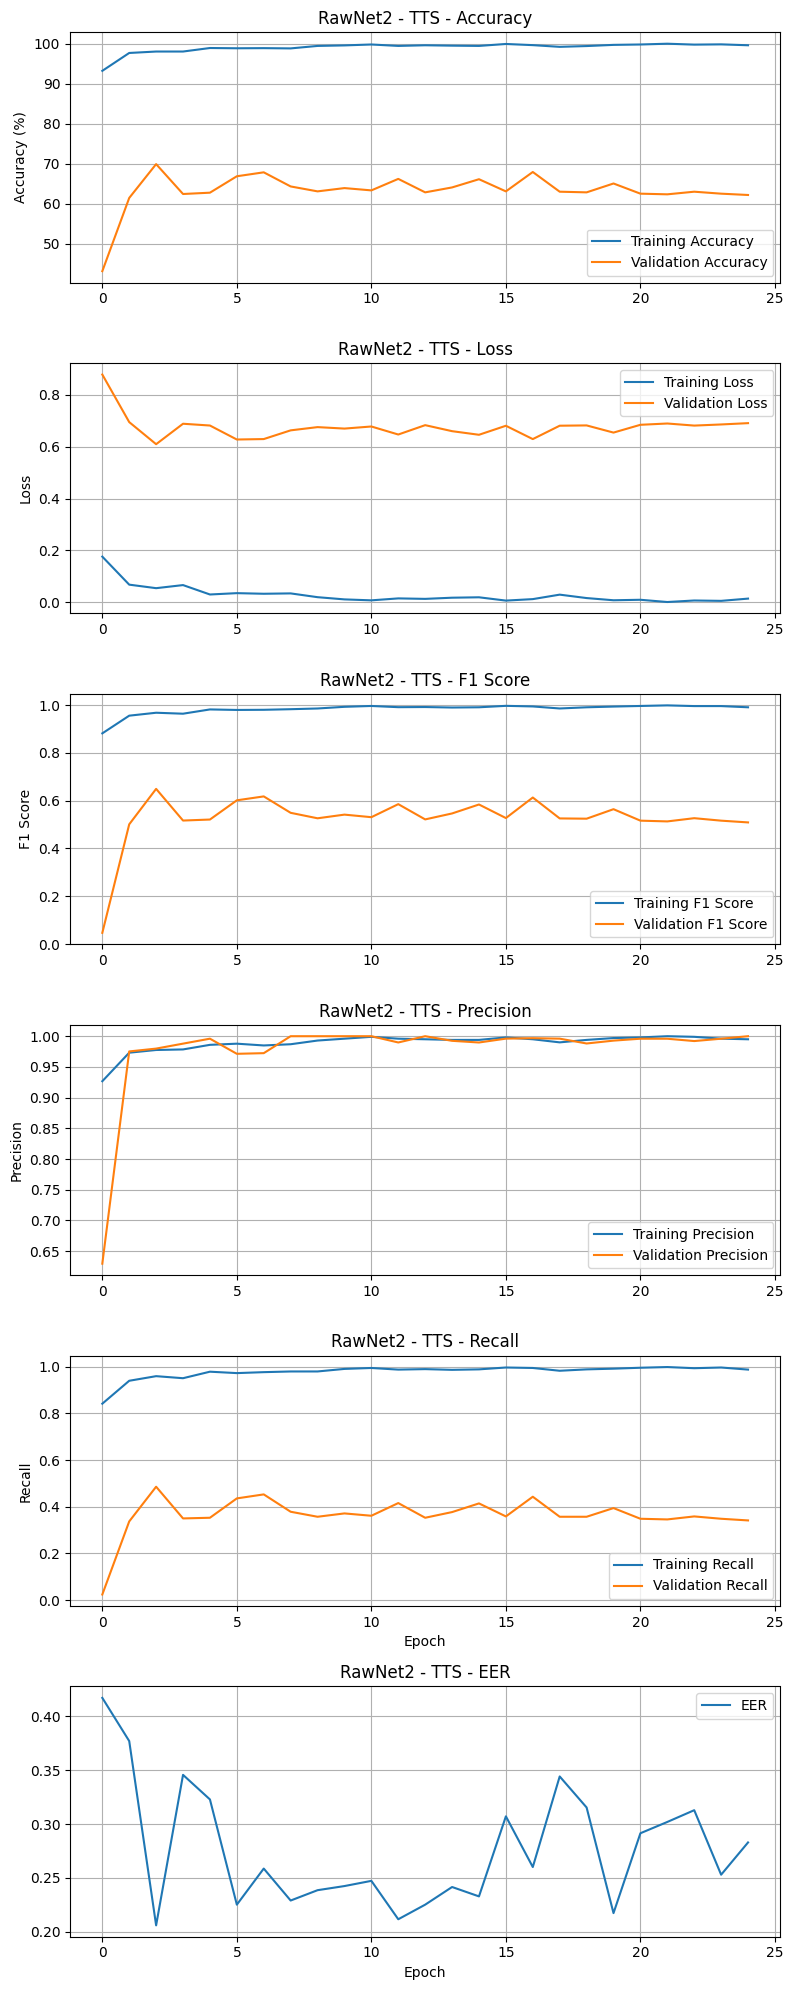

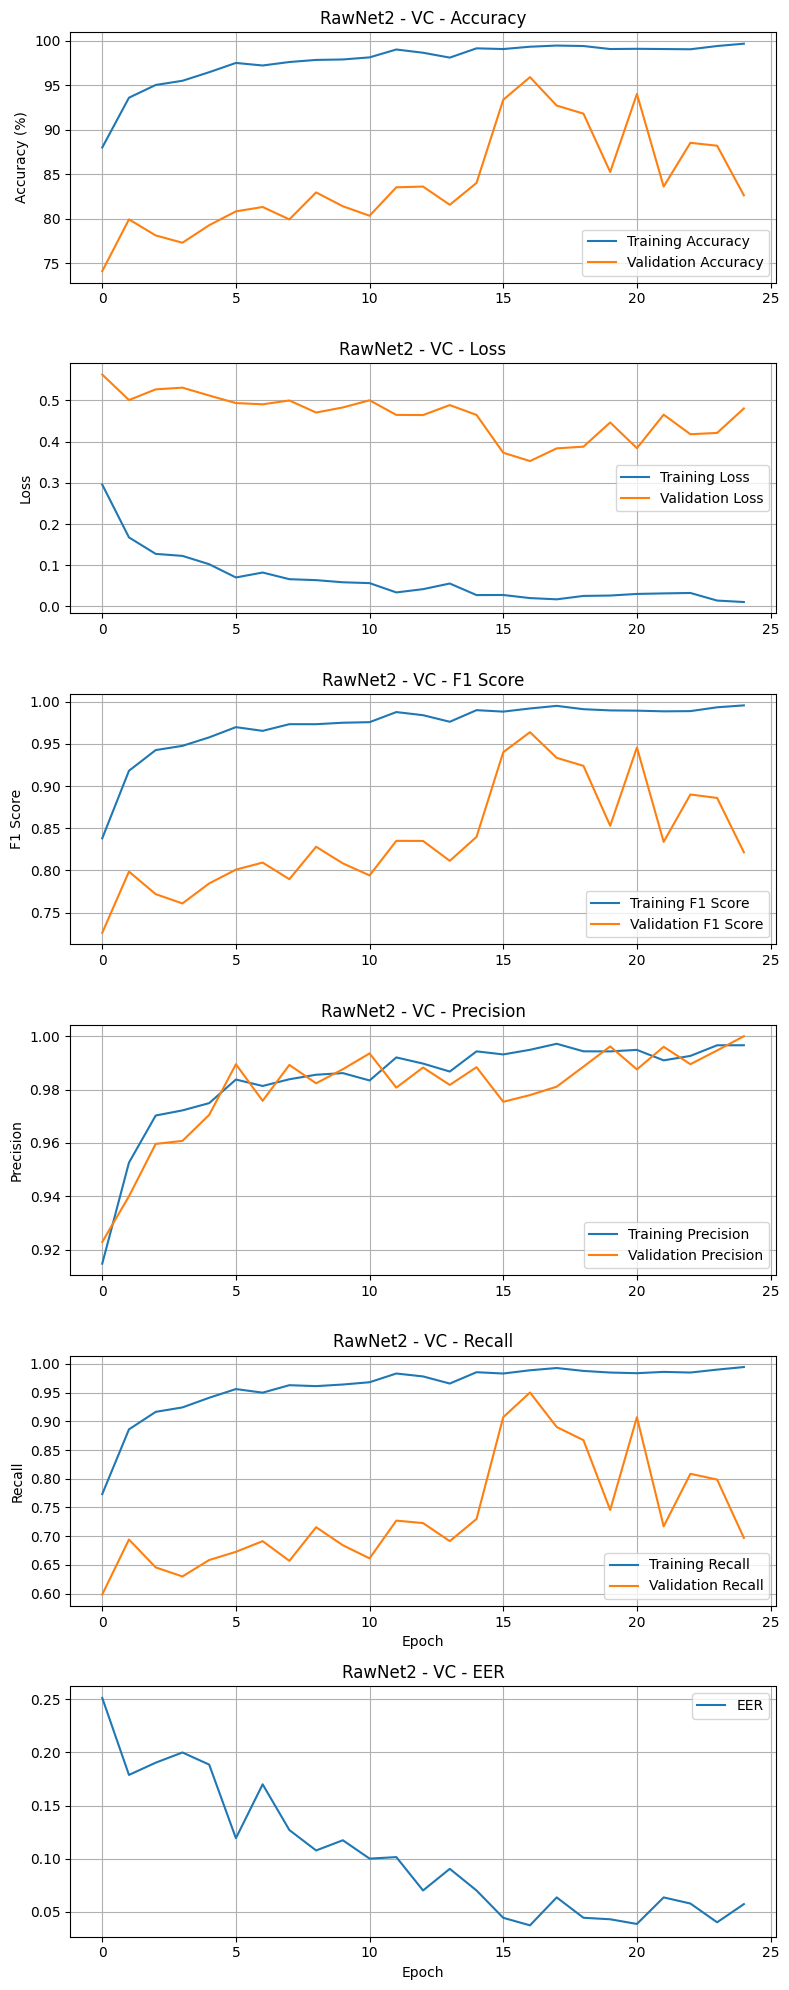

In [17]:
import matplotlib.pyplot as plt

def plot_history(history, title_prefix):
    plt.figure(figsize=(8, 20))

    # Accuracy
    plt.subplot(6, 1, 1)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title_prefix} - Accuracy')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(6, 1, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'{title_prefix} - Loss')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # F1 Score
    plt.subplot(6, 1, 3)
    plt.plot(history['f1_score'], label='Training F1 Score')
    plt.plot(history['val_f1_score'], label='Validation F1 Score')
    plt.title(f'{title_prefix} - F1 Score')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)

    # Precision
    plt.subplot(6, 1, 4)
    plt.plot(history['precision'], label='Training Precision')
    plt.plot(history['val_precision'], label='Validation Precision')
    plt.title(f'{title_prefix} - Precision')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)

    # Recall
    plt.subplot(6, 1, 5)
    plt.plot(history['recall'], label='Training Recall')
    plt.plot(history['val_recall'], label='Validation Recall')
    plt.title(f'{title_prefix} - Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid(True)

    # EER
    plt.subplot(6, 1, 6)
    plt.plot(history['eer'], label='EER')
    plt.title(f'{title_prefix} - EER')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()



plot_history(histories['tts'], "RawNet2 - TTS")
plot_history(histories['vc'], "RawNet2 - VC")
# plot_history(histories['overall'], "RawNet2 - Overall")


In [16]:
import shutil

source_dir = "/content/models"
destination_dir = "/content/drive/MyDrive/3_Rawnet2_Models"

shutil.copytree(source_dir, destination_dir)

'/content/drive/MyDrive/3_Rawnet2_Models'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [18]:
test_df = get_file_df(test_path)
us_path = os.path.join(dataset_path, 'us')

us_df = get_file_df(us_path)

test_df = pd.concat([test_df, us_df], ignore_index=True)

test_df.to_csv("test_metadata.csv", index=False)




In [19]:
df_2 = pd.read_csv("test_metadata.csv")
df_2.head()

,path,label,fake_type,gender,id,set,sentence,duration,samples,sr
0,/content/drive/MyDrive/Dataset/Test/Real_M_P29...,0,Real,Male,P29,E,18,5.572789,245760,44100
1,/content/drive/MyDrive/Dataset/Test/Real_M_P29...,0,Real,Male,P29,E,17,8.370794,369152,44100
2,/content/drive/MyDrive/Dataset/Test/Real_M_P29...,0,Real,Male,P29,E,10,5.712109,251904,44100
3,/content/drive/MyDrive/Dataset/Test/Real_M_P29...,0,Real,Male,P29,E,12,6.211338,273920,44100
4,/content/drive/MyDrive/Dataset/Test/Real_M_P29...,0,Real,Male,P29,E,1,7.581315,334336,44100


In [20]:

transform = lambda x: pad(x, max_len=64000)

test_dataset = AudioDataset(test_df, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [21]:
test_dataset.__len__()


1650

In [27]:
import torch
import numpy as np
from sklearn.metrics import roc_curve, accuracy_score

def compute_eer(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    fnr = 1 - tpr
    eer_threshold = thresholds[np.nanargmin(np.abs(fnr - fpr))]
    eer = fpr[np.nanargmin(np.abs(fnr - fpr))]
    return eer, eer_threshold

def test_chained_models(model1, model2, model3, test_loader, device):
    model1.eval()
    model2.eval()
    model3.eval()

    all_preds_multiclass = []  # 0 = Real, 1 = TTS, 2 = VC
    all_preds_binary = []      # 0 = Real, 1 = Fake
    all_labels_multiclass = [] # true multiclass labels (if available)
    all_labels_binary = []     # Ground truth binary labels
    all_scores_overall = []    # Model 3 probabilities (for EER & ROC)

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # logits from models
            logits1 = model1(inputs)
            logits2 = model2(inputs)
            logits3 = model3(inputs)

            # predicted class (0=real, 1=fake)
            preds1 = torch.argmax(logits1, dim=1)
            preds2 = torch.argmax(logits2, dim=1)
            preds3 = torch.argmax(logits3, dim=1)

            # probability of fake (class 1)
            probs1 = torch.softmax(logits1, dim=1)[:, 1]
            probs2 = torch.softmax(logits2, dim=1)[:, 1]
            probs3 = torch.softmax(logits3, dim=1)[:, 1]

            for i in range(len(inputs)):
                p1, p2, p3 = preds1[i].item(), preds2[i].item(), preds3[i].item()
                pr1, pr2, pr3 = probs1[i].item(), probs2[i].item(), probs3[i].item()

                # Decision chain
                # if p1 == 1 and p2 == 0:
                #     pred_label = 1  # TTS
                # elif p2 == 1 and p1 == 0:
                #     pred_label = 2  # VC
                # elif p1 == 1 and p2 == 1:
                #     # Conflict: both say fake
                #     if p3 == 0:
                #         pred_label = 0  # Real (model3 says real)
                #     else:
                #         # choose based on higher confidence
                #         pred_label = 1 if pr1 > pr2 else 2
                # else:
                #     # Any model says real → Real
                #     pred_label = 0
                if p3 == 1 or p2 == 1:
                    pred_label = 1  # TTS
                elif p2 == 1 and p1 == 0:
                    pred_label = 2  # VC
                # elif p1 == 1 and p2 == 1:

                #         pred_label = 1 if pr1 > pr2 else 2
                elif p1 == 0 and p2 == 0:
                    pred_label = 0
                else:
                    # Any model says fake → fake
                    pred_label = 0

                all_preds_multiclass.append(pred_label)
                all_preds_binary.append(0 if pred_label == 0 else 1)

                # Assuming original labels are binary (0=real,1=fake),
                # for multiclass ground truth you'll need to adapt your test_loader
                # For now, treat labels as binary, so:
                all_labels_binary.append(labels[i].item())
                all_labels_multiclass.append(labels[i].item())  # if multiclass labels are available, replace here

                all_scores_overall.append(pr3)  # probability from model 3

    # Metrics
    eer, _ = compute_eer(all_labels_binary, all_scores_overall)
    acc_binary = accuracy_score(all_labels_binary, all_preds_binary)
    acc_multiclass = accuracy_score(all_labels_binary, [0 if p == 0 else 1 for p in all_preds_multiclass])

    return {
        "preds_multiclass": all_preds_multiclass,
        "preds_binary": all_preds_binary,
        "labels_binary": all_labels_binary,
        "labels_multiclass": all_labels_multiclass,
        "probs_overall": all_scores_overall,
        "eer": eer,
        "acc_binary": acc_binary,
        "acc_multiclass": acc_multiclass
    }


In [28]:
# ---- Config ----
config = {
    'first_conv': 128,
    'in_channels': 1,
    'filts': [128, [128, 128], [128, 512], [512, 512]],
    'nb_fc_node': 1024,
    'gru_node': 1024,
    'nb_gru_layer': 3,
    'nb_classes': 2,
    'nb_samp': 64000
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ---- Model paths ----
model_vc_path       = "/content/drive/MyDrive/3_Rawnet2_Models/rawnet2_vc.pth"
model_tts_path      = "/content/drive/MyDrive/3_Rawnet2_Models/rawnet2_tts.pth"
model_overall_path  = "/content/drive/MyDrive/3_Rawnet2_Models/best.pth"

# ---- Load Models ----
model_vc = RawNet(config, device=device).to(device)
model_vc.load_state_dict(torch.load(model_vc_path, map_location=device))
config = {
    'first_conv': 128,
    'in_channels': 1,
    'filts': [128, [128, 128], [128, 512], [512, 512]],
    'nb_fc_node': 1024,
    'gru_node': 1024,
    'nb_gru_layer': 3,
    'nb_classes': 2,
    'nb_samp': 64000
}

model_tts = RawNet(config, device=device).to(device)
model_tts.load_state_dict(torch.load(model_tts_path, map_location=device))
config = {
    'first_conv': 128,
    'in_channels': 1,
    'filts': [128, [128, 128], [128, 512], [512, 512]],
    'nb_fc_node': 1024,
    'gru_node': 1024,
    'nb_gru_layer': 3,
    'nb_classes': 2,
    'nb_samp': 64000
}

model_overall = RawNet(config, device=device).to(device)
model_overall.load_state_dict(torch.load(model_overall_path, map_location=device))

# ---- Test ----
results = test_chained_models(
    model_tts,      # Model 1: Real vs TTS
    model_vc,       # Model 2: Real vs VC
    model_overall,  # Model 3: Real vs Fake overall
    test_loader,
    device
)

# ---- Results ----
print(f"EER (binary real/fake): {results['eer']*100:.2f}%")
print(f"Binary accuracy: {results['acc_binary']*100:.2f}%")
print(f"Multiclass-as-binary accuracy: {results['acc_multiclass']*100:.2f}%")


/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

EER (binary real/fake): 21.14%
Binary accuracy: 75.39%
Multiclass-as-binary accuracy: 75.39%


Multiclass Classification Report (Real=0, TTS=1, VC=2):
              precision    recall  f1-score   support

        Real     0.7049    0.7471    0.7254       700
         TTS     0.9585    0.2916    0.4471       950
          VC     0.0000    0.0000    0.0000         0

    accuracy                         0.4848      1650
   macro avg     0.5544    0.3462    0.3908      1650
weighted avg     0.8509    0.4848    0.5652      1650

Real accuracy: 74.71%
TTS accuracy: 29.16%
VC accuracy: 0.00%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


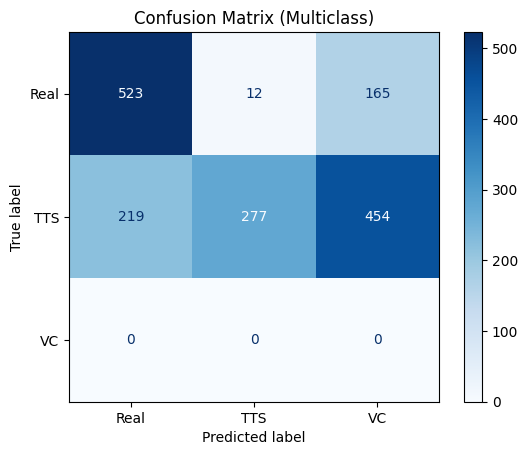


Binary Classification Report (Real=0, Fake=1):
              precision    recall  f1-score   support

        Real     0.7049    0.7471    0.7254       700
        Fake     0.8051    0.7695    0.7869       950

    accuracy                         0.7600      1650
   macro avg     0.7550    0.7583    0.7561      1650
weighted avg     0.7626    0.7600    0.7608      1650



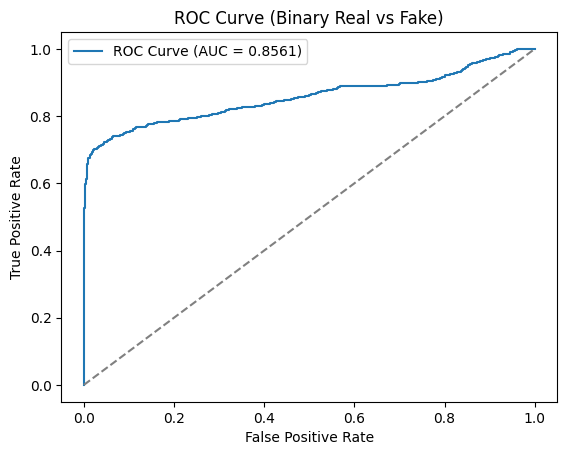

EER: 21.14%


In [24]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, roc_curve, auc

# Convert to numpy
y_true_mc = np.array(results['labels_multiclass'])
y_pred_mc = np.array(results['preds_multiclass'])
y_true_bin = np.array(results['labels_binary'])
y_pred_bin = np.array(results['preds_binary'])
probs_fake = np.array(results['probs_overall'])

# 1. Classification report multiclass
print("Multiclass Classification Report (Real=0, TTS=1, VC=2):")
print(classification_report(y_true_mc, y_pred_mc, target_names=["Real", "TTS", "VC"], digits=4))

# 2. Per-class accuracy
class_names = ["Real", "TTS", "VC"]
for i, cls in enumerate(class_names):
    mask = (y_true_mc == i)
    if mask.any():
        acc = (y_pred_mc[mask] == i).mean()
    else:
        acc = 0
    print(f"{cls} accuracy: {acc*100:.2f}%")

# 3. Confusion matrix plot
cm = confusion_matrix(y_true_mc, y_pred_mc)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Multiclass)")
plt.show()

# 4. Binary classification report & metrics
print("\nBinary Classification Report (Real=0, Fake=1):")
print(classification_report(y_true_bin, y_pred_bin, target_names=["Real", "Fake"], digits=4))

# 5. ROC curve for binary real/fake
fpr, tpr, thresholds = roc_curve(y_true_bin, probs_fake)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0,1],[0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Binary Real vs Fake)")
plt.legend()
plt.show()

# 6. Print EER
print(f"EER: {results['eer']*100:.2f}%")